In [49]:
import jax
import jax.random as jr
from flowjax.flows import masked_autoregressive_flow
from flowjax.bijections import RationalQuadraticSpline, Invert, Tanh
from flowjax.train import fit_to_data
import matplotlib.pyplot as plt
from flowjax.distributions import Uniform, Transformed, _StandardUniform
import jax.numpy as jnp
from flowjax.wrappers import NonTrainable
import equinox as eqx
jax.config.update("jax_enable_x64", True)
from frugal_flows.basic_flows import (
    masked_autoregressive_flow_first_uniform,
    masked_independent_flow,
    masked_autoregressive_flow_transformer_cond,
    masked_autoregressive_flow_masked_cond,
)

In [33]:
nvars = 1
keys = jr.split(jr.PRNGKey(0), 6)
N=5000
x_cond = jnp.expand_dims(jnp.hstack([jnp.ones(int(N/2))*0, jnp.ones(int(N/2))*1]),axis=1)
y = jr.normal(keys[1], shape=(N, nvars)) + x_cond

In [40]:
N = 10000
nvars=2

z_0 = jr.multivariate_normal(keys[0], jnp.array([0.,0.]), jnp.array([[1., 0],[0, 1.]]), shape=(int(N/2),))

z_1 = jr.multivariate_normal(keys[1], jnp.array([0.,0.]), jnp.array([[1., 0.8],[0.8, 1.]]), shape=(int(N/2),))
z = jnp.vstack([z_0, z_1])

x = jnp.expand_dims(jnp.hstack([jnp.ones(int(N/2))*0, jnp.ones(int(N/2))*1]),axis=1)
# y = jax.random.normal(keys[2], shape=(N,1)) + x + jnp.expand_dims(z.sum(1), axis=1)

In [50]:
base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))

transformer = RationalQuadraticSpline(knots=10, interval=1)

flow = masked_autoregressive_flow_masked_cond(
    key=keys[2],
    base_dist=base_dist,
    transformer=transformer,
    flow_layers=10,
    nn_width=50,
    nn_depth=5,
    cond_dim_mask=x.shape[1],
    ) # Support on [-1, 1]

flow = Transformed(
    flow, Invert(Tanh(flow.shape))
) # Unbounded support


flow = flow.merge_transforms()

assert isinstance(flow.base_dist, _StandardUniform)

flow = eqx.tree_at(
    where=lambda flow: flow.bijection.bijections[0],
    pytree=flow,
    replace_fn=NonTrainable,
    )



# Train 
flow, losses = fit_to_data(
    key=keys[3],
    dist=flow,
    x=z,
    learning_rate=1e-3,
    max_patience=10,
    max_epochs=400,
    condition=x,#x_cond,
)

  6%|█████▏                                                                             | 25/400 [00:39<09:50,  1.57s/it, train=2.7389693168604436, val=2.754817981710601 (Max patience reached)]


In [51]:
frugal_flow_samples_1 = flow.sample(keys[2], condition=jnp.ones((10000,1))) #

In [52]:
frugal_flow_samples_1.shape

(10000, 2)

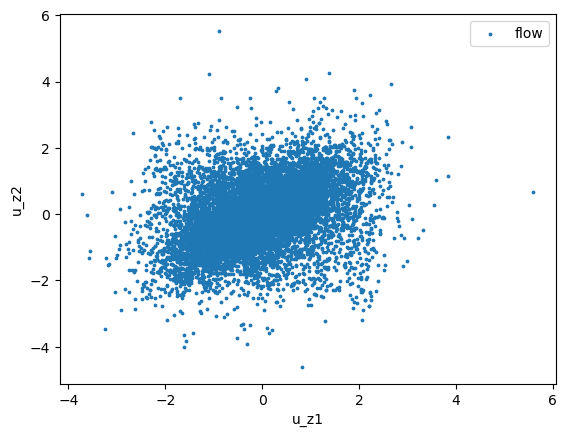

In [53]:
plt.scatter(*frugal_flow_samples_1.T, label="flow", s=3)
# plt.scatter(*res['u_z_cont'].T, label="target", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

In [54]:
frugal_flow_samples_0 = flow.sample(keys[2], condition=jnp.zeros((10000,1))) #

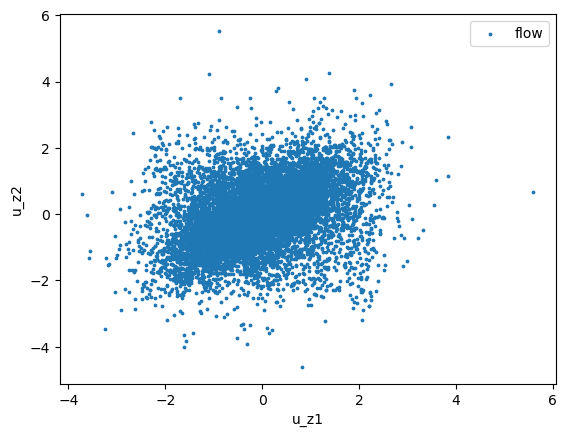

In [55]:
plt.scatter(*frugal_flow_samples_0.T, label="flow", s=3)
# plt.scatter(*res['u_z_cont'].T, label="target", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

 26%|██████████████████▌                                                   | 106/400 [00:59<02:46,  1.77it/s, train=1.5520577726854028, val=1.505223375314297 (Max patience reached)]


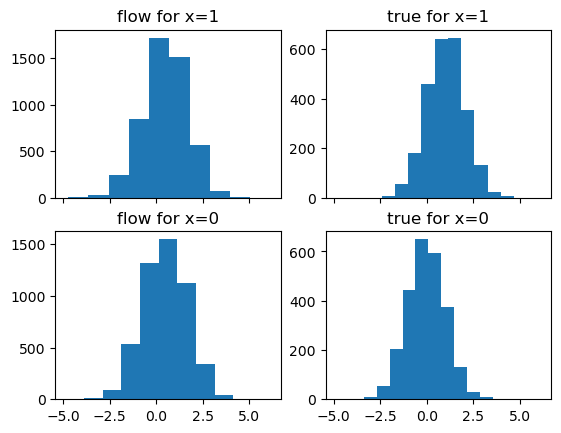

In [ ]:
flow_1 =flow.sample(keys[4], condition=jnp.ones((5000,1)))[:,0]
flow_0 = flow.sample(keys[5], condition=jnp.zeros((5000,1)))[:,0]
y_1 = y[x_cond==1]
y_0 = y[x_cond==0]

fig, ax = plt.subplots(2,2, sharex=True)

ax[0,0].hist(flow_1, label='flow for x=1')
ax[0,0].set_title('flow for x=1')
ax[0,1].hist(y_1, label='true for x=1')
ax[0,1].set_title('true for x=1')
ax[1,0].hist(flow_0, label='flow for x=0')
ax[1,0].set_title('flow for x=0')
ax[1,1].hist(y_0, label='true for x=0')
ax[1,1].set_title('true for x=0')
plt.show()

In [31]:
flow_1.mean(), y_1.mean()

(Array(2.35633267, dtype=float64), Array(5.01938287, dtype=float64))

In [32]:
flow_0.mean(), y_0.mean()

(Array(2.32740277, dtype=float64), Array(-0.03148025, dtype=float64))